In [1]:
%matplotlib widget
from matplotlib.ticker import FuncFormatter
import pandas as pd

In [2]:
FDIR = "/scratch/seismo/kashyap/processed/p11-seismo-xl/freqfiles/freqfiles_KIC8006161"
MFDIR = "/data/seismo/kashyap/codes/p11-seismo-xl/data/"
FPFX = "freq_KIC8006161"

In [3]:
modefit_data = pd.read_csv(f'{MFDIR}/santos2018-008006161.csv')
count = 24
numenn = 11

nu0 = np.zeros((numenn, count+1))
nu1 = np.zeros((numenn, count+1))
nu2 = np.zeros((numenn, count+1))

In [4]:
for tidx in range(1, 25):
    try:
        testdata = np.loadtxt(f"{FDIR}/{FPFX}_{tidx}.txt")
        nu0[:, tidx] = testdata[:, 0]
        nu1[:, tidx] = testdata[:, 3]
        nu2[:, tidx] = testdata[:, 6]
    except FileNotFoundError:
        print(f"tidx = {tidx} Not found")
        continue

In [5]:
def format_ticks(value, _):
    return f"{value:.2f}"

# Apply the formatter to the y-axis

def nanmean(arr, axis=0):
    nan_count = np.isnan(arr).sum(axis=axis)
    val_count = arr.shape[axis] - nan_count
    new_arr = arr*1.
    new_arr[np.isnan(arr)] = 0.
    meanvals = np.sum(new_arr, axis=axis)/val_count
    return meanvals
    
nu0mean = nanmean(nu0[:, 1:], axis=0)
nu1mean = nanmean(nu1[:, 1:], axis=0)
nu2mean = nanmean(nu2[:, 1:], axis=0)

delnu0 = nu0[:, 1:] #- nu0mean
delnu1 = nu1[:, 1:] #- nu1mean
delnu2 = nu2[:, 1:] #- nu2mean

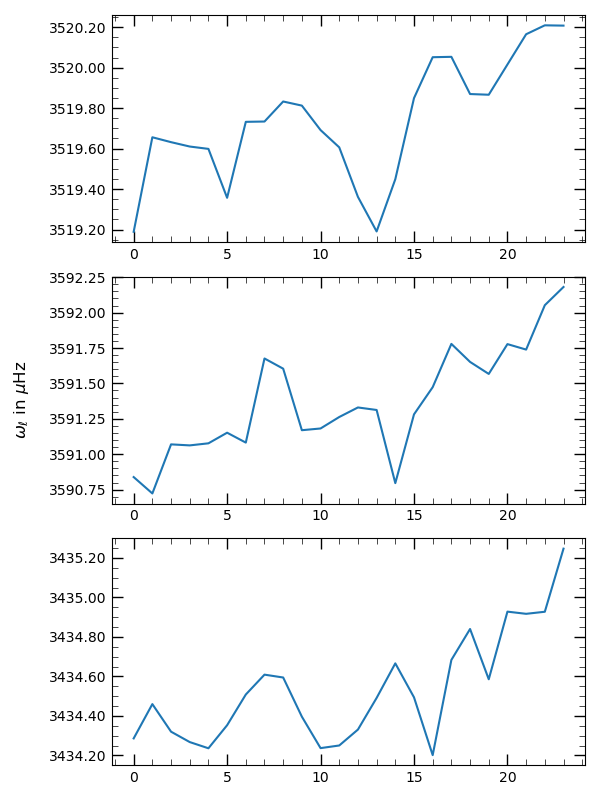

In [6]:
plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))
axs[0].plot(nanmean(delnu0, axis=0))
axs[1].plot(nanmean(delnu1, axis=0))
axs[2].plot(nanmean(delnu2, axis=0))
for _ax in axs: 
    _ax.ticklabel_format(useOffset=False, style='plain')
    _ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
fig.supylabel('$\omega_{\ell}$ in $\mu$Hz')
fig.tight_layout()

In [7]:
from sgkutils import readh5
from scipy.interpolate import interp1d
KDIR = "/scratch/seismo/kashyap/processed/sun-intg/kepler-008006161"
kdict = readh5(f'{KDIR}/ksth-008006161-N180-s45.h5')

In [8]:
def get_weights(freqs, ell=0):
    mask_ell = kdict['ells']==ell
    amps = kdict['amps'][mask_ell]
    gammas = kdict['gammas'][mask_ell]
    nus = kdict['nus'][mask_ell]
    aint = interp1d(nus, amps, bounds_error=False, fill_value=0.)
    gint = interp1d(nus, gammas, bounds_error=False, fill_value=1.)
    af = aint(freqs*1e-6)
    gf = gint(freqs*1e-6)
    a2g = af*af/gf
    return a2g/a2g.sum()

[0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.]
0.09090909090909091


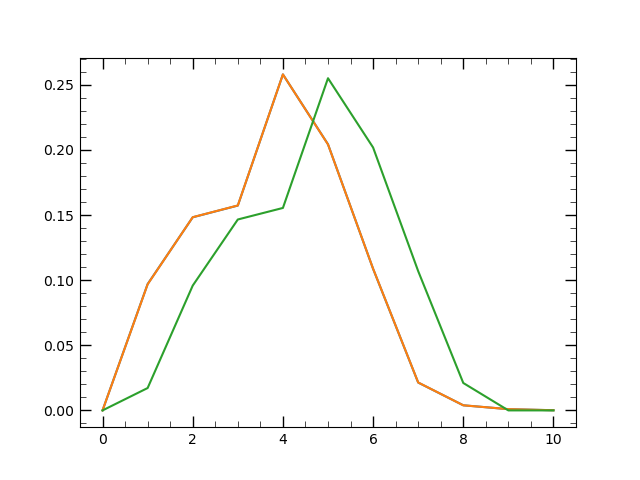

In [9]:
wnl0 = get_weights(nu0[:, 1], ell=0)
wnl1 = get_weights(nu1[:, 1], ell=1)
dnu2 = nu2[:, 1]
dnu2[np.isnan(dnu2)] = 0.
wnl2 = get_weights(dnu2, ell=2)


uwnl0 = np.zeros_like(wnl0)
uwnl1 = np.zeros_like(wnl1)
uwnl2 = np.zeros_like(wnl2)
sidx = 3
uwnl0[sidx:sidx+5] = 1
uwnl1[sidx:sidx+5] = 1
uwnl2[sidx:sidx+5] = 1
print(uwnl0)
uwnl0 = uwnl0/uwnl0.sum()
uwnl1 = uwnl1/uwnl1.sum()
uwnl2 = uwnl2/uwnl2.sum()
print(uwnl0.mean())

plt.figure()
plt.plot(wnl0)
plt.plot(wnl1)
plt.plot(wnl2)

3334.241885917969
3405.6180283248364
3460.450819949779


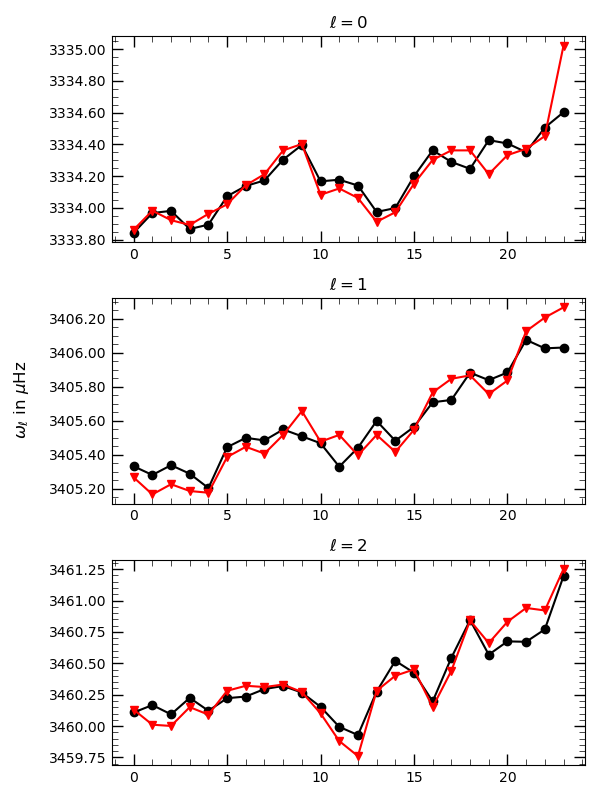

In [12]:
obs0 = wnl0 @ delnu0
obs1 = wnl1 @ delnu1
dnu2 = delnu2*1.
dnu2[np.isnan(dnu2)] = 0.
obs2 = wnl2 @ dnu2

obs0u = uwnl0 @ delnu0
obs1u = uwnl1 @ delnu1
obs2u = uwnl2 @ dnu2

def shiftmean(arr, refarr):
    _dcs = nanmean(refarr) - nanmean(arr)
    print(_dcs)
    return arr + _dcs

plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))
tidx = np.arange(len(obs0))
axs[0].plot(tidx, obs0, 'o-k')
axs[1].plot(tidx, obs1, 'o-k')
axs[2].plot(tidx, obs2, 'o-k')
axs[0].plot(tidx, shiftmean(modefit_data['delnu0'], obs0), 'v-r')
axs[1].plot(tidx, shiftmean(modefit_data['delnu1'], obs1), 'v-r')
axs[2].plot(tidx, shiftmean(modefit_data['delnu2'], obs2), 'v-r')
for idx, _ax in enumerate(axs): 
    _ax.ticklabel_format(useOffset=False, style='plain')
    _ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    _ax.set_title('$\\ell = $' + f"{idx}")
fig.supylabel('$\omega_{\ell}$ in $\mu$Hz')
fig.tight_layout()

-3334.241885917969
-3405.6180283248364
-3460.450819949779
-3518.879670194833
-3590.5011350745835
-3509.1587876567496


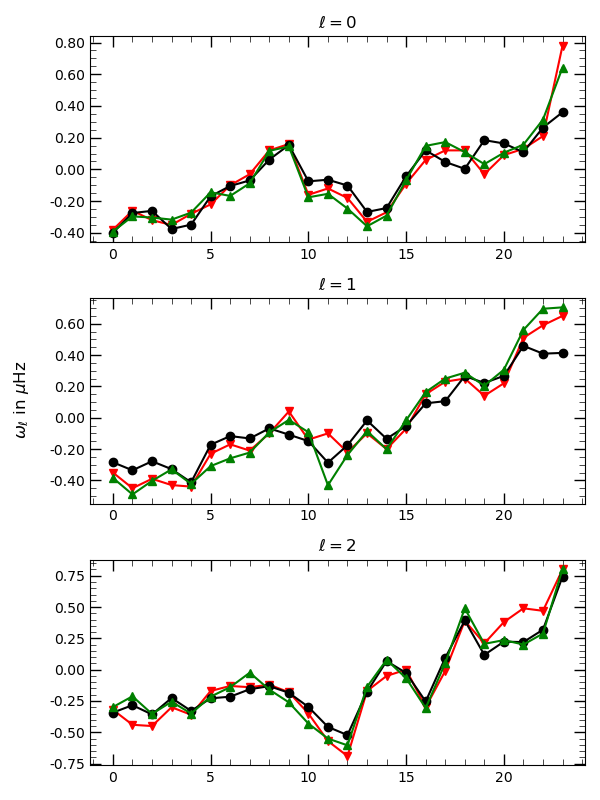

In [23]:
plt.close('all')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 8))
tidx = np.arange(len(obs0))
axs[0].plot(tidx, modefit_data['delnu0'], 'v-r')
axs[1].plot(tidx, modefit_data['delnu1'], 'v-r')
axs[2].plot(tidx, modefit_data['delnu2'], 'v-r')
axs[0].plot(tidx, shiftmean(obs0, modefit_data['delnu0']), 'o-k')
axs[1].plot(tidx, shiftmean(obs1, modefit_data['delnu1']), 'o-k')
axs[2].plot(tidx, shiftmean(obs2, modefit_data['delnu2']), 'o-k')
axs[0].plot(tidx, shiftmean(obs0u, modefit_data['delnu0']), '^-g')
axs[1].plot(tidx, shiftmean(obs1u, modefit_data['delnu1']), '^-g')
axs[2].plot(tidx, shiftmean(obs2u, modefit_data['delnu2']), '^-g')
for idx, _ax in enumerate(axs): 
    _ax.ticklabel_format(useOffset=False, style='plain')
    _ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    _ax.set_title('$\\ell = $' + f"{idx}")
fig.supylabel('$\omega_{\ell}$ in $\mu$Hz')
fig.tight_layout()

In [24]:
modefit_data['delnu0mcmc'] = shiftmean(obs0u, modefit_data['delnu0'])
modefit_data['delnu1mcmc'] = shiftmean(obs1u, modefit_data['delnu1'])
modefit_data['delnu2mcmc'] = shiftmean(obs2u, modefit_data['delnu2'])

-3518.879670194833
-3590.5011350745835
-3509.1587876567496


In [25]:
modefit_data

,time,duty-cycle,tgran,tgran_error,delnu0,delnu0_error,delnu1,delnu1_error,delnu2,delnu2_error,delnu,delnu_error,lnS,lnS_error,delnux,delnux_error,delnu0mcmc,delnu1mcmc,delnu2mcmc
0,345,0.97,183.4,2.6,-0.38,0.06,-0.35,0.07,-0.32,0.13,-0.37,0.05,0.79,0.17,-0.32,0.10,-0.391372,-0.384144,-0.298449
1,390,0.97,181.2,0.3,-0.26,0.07,-0.45,0.07,-0.44,0.15,-0.34,0.05,0.69,0.17,-0.33,0.09,-0.296101,-0.489764,-0.212742
2,435,0.96,184.6,6.9,-0.32,0.06,-0.39,0.08,-0.45,0.14,-0.35,0.05,0.78,0.15,-0.32,0.09,-0.303360,-0.403239,-0.353138
3,480,0.97,186.4,0.2,-0.35,0.05,-0.43,0.07,-0.30,0.12,-0.38,0.04,1.11,0.16,-0.35,0.09,-0.316426,-0.329659,-0.255938
4,525,0.96,183.2,0.6,-0.28,0.05,-0.44,0.08,-0.36,0.12,-0.33,0.04,0.98,0.15,-0.34,0.11,-0.272274,-0.422664,-0.350186
5,570,0.80,194.8,0.6,-0.22,0.06,-0.23,0.09,-0.17,0.15,-0.22,0.05,0.70,0.14,-0.10,0.12,-0.144115,-0.308886,-0.215117
6,615,0.78,206.4,0.4,-0.10,0.08,-0.17,0.09,-0.13,0.18,-0.13,0.06,0.45,0.14,-0.13,0.13,-0.167126,-0.259220,-0.139578
7,660,0.89,193.7,0.0,-0.03,0.08,-0.21,0.09,-0.14,0.17,-0.11,0.06,0.59,0.14,-0.10,0.11,-0.087345,-0.222496,-0.024131
8,705,0.93,186.5,4.5,0.12,0.09,-0.10,0.09,-0.12,0.17,0.01,0.06,0.57,0.16,0.02,0.12,0.116716,-0.093768,-0.159007
9,750,0.97,187.2,0.2,0.16,0.10,0.04,0.02,-0.18,0.14,0.02,0.07,0.25,0.16,0.01,0.13,0.145044,-0.013932,-0.260934


In [26]:
modefit_data.to_csv(f'{MFDIR}/santos2018b-008006161.csv')